# 1 Imports

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from meteostat import Hourly, Stations

from ev_load_fc.preprocessing.loading import col_standardisation, filtered_chunking
from ev_load_fc.preprocessing.analysis import ts_completeness, plot_time_series
from ev_load_fc.preprocessing.preprocessing import mad_outlier_bounds, cap_outliers_mad
from ev_load_fc.config import CFG, resolve_path
raw_data_path = resolve_path(CFG["paths"]["raw_data"])

min_timestamp = datetime(2017,8,1,0,0,0)
max_timestamp = datetime(2020,3,1,0,0,0)
weather_data_path = raw_data_path / 'WeatherEvents_Aug16_Dec20_Publish.csv'

In [2]:
# # Use filtered_chunking to load only the relevant date range and state of California
# weather_data = filtered_chunking(weather_data_path, 
#                                  start_date_col='StartTime(UTC)', 
#                                  end_date_col='EndTime(UTC)',
#                                  date_format='%Y-%m-%d %H:%M:%S',
#                                  chunksize=100000, 
#                                  min_date=min_timestamp, 
#                                  max_date=max_timestamp, 
#                                  state_list=['CA'])

# 2 Formatting

In [4]:
weather_data.head()

,EventId,Type,Severity,StartTime(UTC),EndTime(UTC),TimeZone,LocationLat,LocationLng,AirportCode,City,County,State,ZipCode
0,W-85316,Fog,Severe,2017-08-01 12:53:00,2017-08-01 13:35:00,US/Pacific,36.9394,-121.79,KWVI,Freedom,Santa Cruz,CA,95019.0
1,W-85317,Fog,Severe,2017-08-01 13:53:00,2017-08-01 15:49:00,US/Pacific,36.9394,-121.79,KWVI,Freedom,Santa Cruz,CA,95019.0
2,W-85318,Fog,Severe,2017-08-02 14:55:00,2017-08-02 15:16:00,US/Pacific,36.9394,-121.79,KWVI,Freedom,Santa Cruz,CA,95019.0
3,W-85319,Fog,Severe,2017-08-05 11:01:00,2017-08-05 11:14:00,US/Pacific,36.9394,-121.79,KWVI,Freedom,Santa Cruz,CA,95019.0
4,W-85320,Fog,Severe,2017-08-05 14:22:00,2017-08-05 15:13:00,US/Pacific,36.9394,-121.79,KWVI,Freedom,Santa Cruz,CA,95019.0


In [5]:
# Convert all column names to lower case, with words only separated by underscores and cutting out text in brackets
weather_data = col_standardisation(weather_data)

weather_data.columns

Index(['eventid', 'type', 'severity', 'starttime', 'endtime', 'timezone',
       'locationlat', 'locationlng', 'airportcode', 'city', 'county', 'state',
       'zipcode'],
      dtype='object')

In [6]:
# Convert all date columns to pandas datetime
date_cols = ['starttime','endtime']
for col in date_cols:
    weather_data[col] = pd.to_datetime(weather_data[col], format="%Y-%m-%d %H:%M:%S")
    
weather_data.dtypes

eventid                object
type                   object
severity               object
starttime      datetime64[ns]
endtime        datetime64[ns]
timezone               object
locationlat           float64
locationlng           float64
airportcode            object
city                   object
county                 object
state                  object
zipcode               float64
dtype: object

# 3 Initial Checks

In [6]:
weather_data.describe()

,starttime,endtime,locationlat,locationlng,zipcode
count,128776,128776,128776.000000,128776.000000,127358.000000
mean,2018-12-21 23:23:25.354258944,2018-12-22 01:17:22.886251776,36.648614,-120.213196,93908.281090
min,2017-08-01 03:21:00,2017-08-01 03:45:00,32.563000,-124.238000,90007.000000
25%,2018-04-07 11:54:00,2018-04-07 13:00:00,34.211900,-121.958500,92626.000000
50%,2019-01-17 07:53:00,2019-01-17 08:56:00,36.780000,-120.467500,93905.000000
75%,2019-07-22 23:54:30,2019-07-23 01:00:45,38.503700,-118.291200,95503.000000
max,2020-02-29 23:35:00,2020-02-29 23:56:00,41.783700,-114.618900,96161.000000
std,NaN,NaN,2.595967,2.197834,1617.934369


In [7]:
# Unique values per column
weather_data.nunique()

eventid        128776
type                7
severity            6
starttime       95962
endtime         95030
timezone            2
locationlat       135
locationlng       135
airportcode       135
city              120
county             47
state               1
zipcode           132
dtype: int64

In [8]:
# Missings breakdown
weather_data.isnull().sum() 

eventid           0
type              0
severity          0
starttime         0
endtime           0
timezone          0
locationlat       0
locationlng       0
airportcode       0
city           1418
county            0
state             0
zipcode        1418
dtype: int64

In [9]:
# Duplicates
weather_data[weather_data.duplicated()]

,eventid,type,severity,starttime,endtime,timezone,locationlat,locationlng,airportcode,city,county,state,zipcode


In [10]:
weather_data['county'].value_counts()
# States surrounding Palo Alto: 'San Mateo', 'Santa Clara', 'Alameda', 'San Francisco'

county
Los Angeles        11510
San Diego          11137
Santa Barbara       7232
San Bernardino      6343
Humboldt            6261
Kern                6032
San Mateo           5829
Riverside           4179
Sacramento          3561
Sonoma              3299
Siskiyou            3297
Monterey            3287
Yuba                3089
Placer              2935
Orange              2928
Solano              2893
Alameda             2861
San Luis Obispo     2799
Del Norte           2761
Santa Clara         2691
Kings               2495
Mono                2192
Tulare              2028
El Dorado           1981
Nevada              1934
Ventura             1902
Marin               1545
Merced              1509
Modoc               1494
Ventura County      1418
Napa                1369
Madera              1356
Santa Cruz          1322
Mendocino           1306
Butte               1247
Shasta              1171
San Joaquin         1057
San Benito           929
Tehama               921
Stanislaus        

In [11]:
weather_data = weather_data[weather_data['county'].isin(['San Mateo', 'Santa Clara', 'Alameda'])]

In [12]:
weather_data['city'].value_counts()
# Cities closest to Palo Alto are 'Palo Alto', 'Mountain View', 'San Carlos'

city
Half Moon Bay           4333
San Martin              1077
Oakland                 1028
Livermore-Pleasanton     931
San Jose                 903
Hayward                  902
San Carlos               811
San Francisco            685
Mountain View            468
Palo Alto                243
Name: count, dtype: int64

In [13]:
weather_data = weather_data[weather_data['city'].isin(['Palo Alto', 'Mountain View', 'San Carlos'])]

In [14]:
pd.crosstab(weather_data['locationlat'], weather_data['locationlng'])

locationlng,-122.2483,-122.1151,-122.0490
locationlat,,,
37.4059,0,0,468
37.4611,0,243,0
37.5119,811,0,0


In [15]:
weather_data['type'].value_counts()

type
Rain     973
Fog      458
Cold      80
Storm     11
Name: count, dtype: int64

In [16]:
weather_data['severity'].value_counts()

severity
Light       911
Moderate    421
Severe      188
Heavy         2
Name: count, dtype: int64

In [17]:
pd.crosstab(weather_data['type'], weather_data['severity'])

severity,Heavy,Light,Moderate,Severe
type,,,,
Cold,0,0,0,80
Fog,0,0,361,97
Rain,2,911,60,0
Storm,0,0,0,11


# 4 Time series completeness and visualisation

In [7]:
# Create additional time-based columns
weather_data['month'] = weather_data['starttime'].dt.to_period('M')
weather_data['date'] = weather_data['starttime'].dt.date
weather_data['hourly_datetime'] = weather_data['starttime'].dt.round('h')
weather_data['weekday'] = weather_data['starttime'].dt.dayofweek

# Duration will be the measureable metric for weather events as it indicates the impact of the event
weather_data['duration'] = (weather_data['endtime'] - weather_data['starttime']) // pd.Timedelta(minutes=1)

In [8]:
negative_w_duration = weather_data[weather_data['duration']<0]['duration'].count()
print(f"Number of weather events with negative durations: {negative_w_duration}")

Number of weather events with negative durations: 0


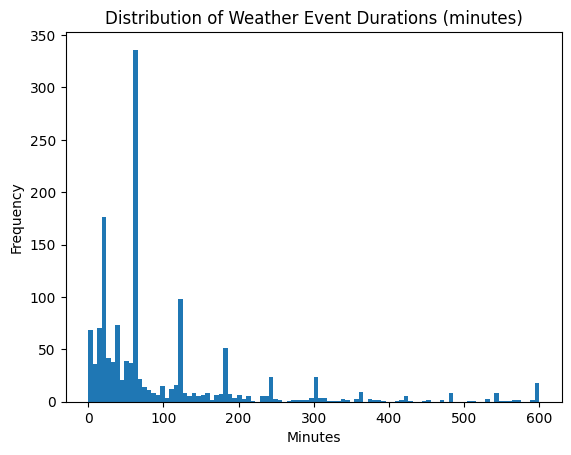

In [19]:
plt.hist(weather_data['duration'],bins=100, range=(0,600))
plt.title('Distribution of Weather Event Durations (minutes)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

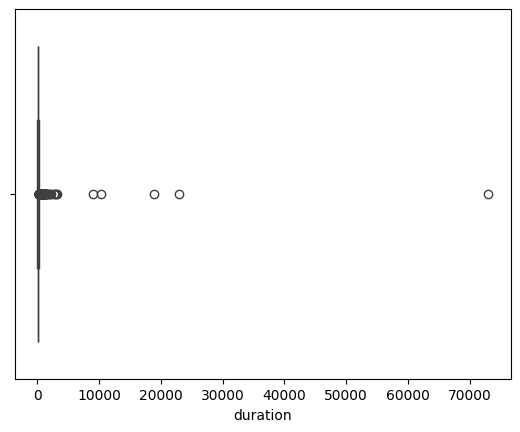

In [20]:
sns.boxplot(x=weather_data['duration'])
plt.show()

In [21]:
# Outlier detection using MAD
MAD_dict = mad_outlier_bounds(weather_data, 'duration', threshold=4)
print(MAD_dict)

{'duration': {'median': np.float64(60.0), 'skewed': True, 'max_val': np.float64(300.0), 'min_val': np.float64(-100.0)}}


In [22]:
# Calculate ratio of days with at least one weather event to total days in dataset
daily_cr = ts_completeness(weather_data, 'D', 1, 'starttime')
print(f"Daily completeness ratio: {daily_cr:.1%}")

Daily completeness ratio: 43.4%


## Hourly Plots

C:\Users\Cameron\projects\ev_load_fc\src\ev_load_fc\data\loading.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


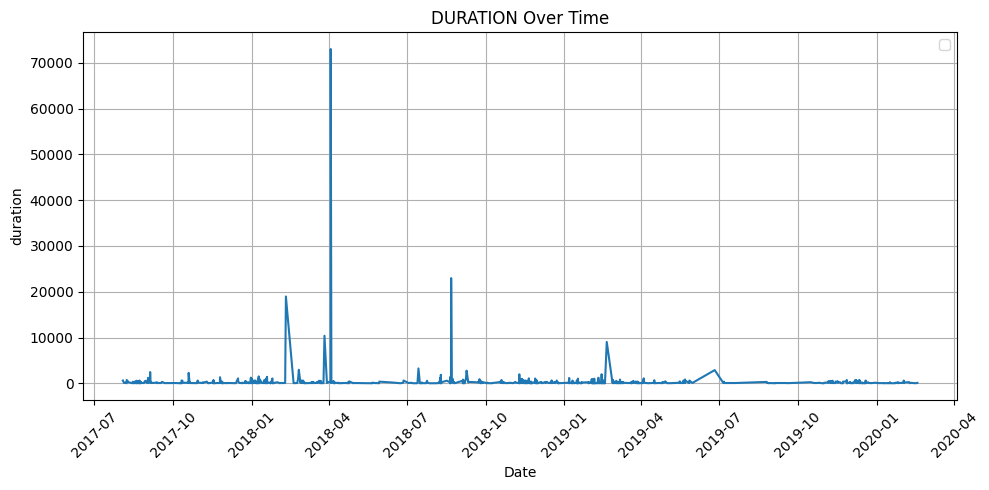

In [23]:
# Plot time series of weather event durations per hour
plot_time_series(weather_data, 'hourly_datetime', 'duration')

In [24]:
hourly_w_duration = pd.DataFrame(weather_data.groupby(by=['hourly_datetime'],sort=True)['duration'].sum().reset_index(), columns=['date','duration'])

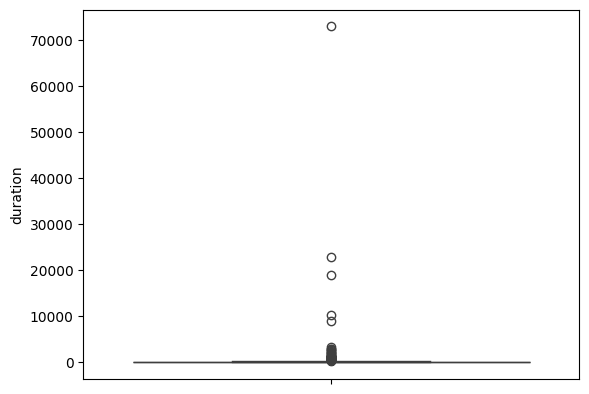

In [25]:
sns.boxplot(hourly_w_duration['duration'])
plt.show()

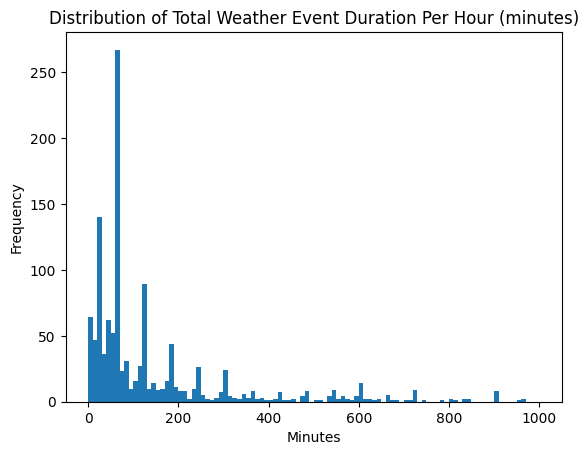

In [26]:
plt.hist(hourly_w_duration['duration'],bins=100, range=(0,1000))
plt.title('Distribution of Total Weather Event Duration Per Hour (minutes)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

In [27]:
# Outlier detection using MAD
hourly_mad_dict = mad_outlier_bounds(hourly_w_duration, 'duration', threshold=4)
print(hourly_mad_dict)

{'duration': {'median': np.float64(60.0), 'skewed': True, 'max_val': np.float64(300.0), 'min_val': np.float64(-100.0)}}


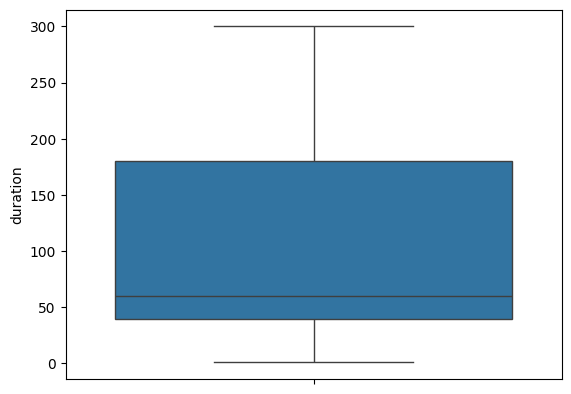

In [28]:
# Cap outliers based off MAD bounds
capped_hourly_w_dur = cap_outliers_mad(hourly_w_duration, hourly_mad_dict)
# Boxplot of capped durations
sns.boxplot(capped_hourly_w_dur['duration'])
plt.show()

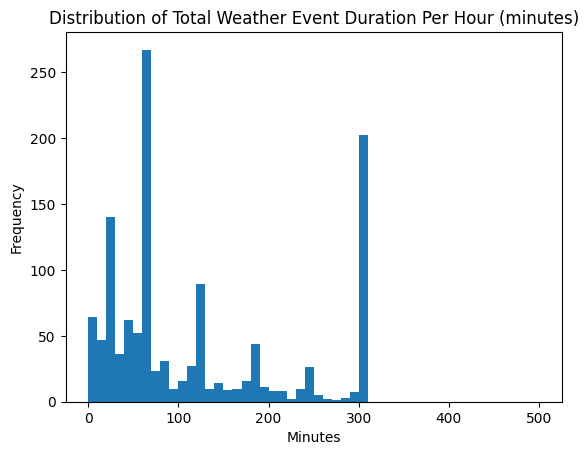

In [29]:
plt.hist(capped_hourly_w_dur['duration'],bins=50, range=(0,500))
plt.title('Distribution of Total Weather Event Duration Per Hour (minutes)')
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.show()

## Daily Plots

C:\Users\Cameron\projects\ev_load_fc\src\ev_load_fc\data\loading.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


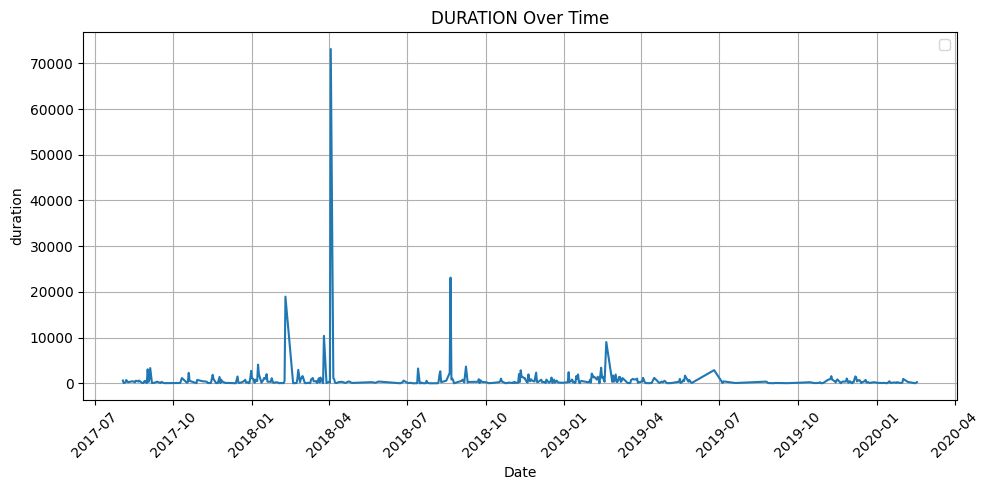

In [30]:
# Plot time series of weather event durations per day
plot_time_series(weather_data, 'date', 'duration')

## Monthly Plots

C:\Users\Cameron\projects\ev_load_fc\src\ev_load_fc\data\loading.py:103: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


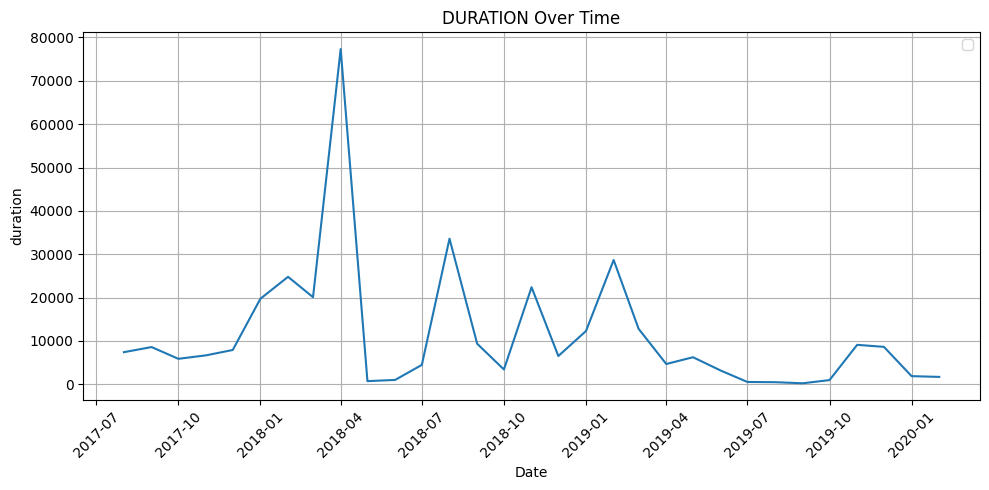

In [31]:
# Plot time series of weather event durations per hour
plot_time_series(weather_data, 'month', 'duration')

# 5 Temperature data from meteostat

In [3]:
# Find weather stations local to Palo alto
pa_long = 37.444178
pa_lat = -122.154721
stations = Stations()
stations = stations.nearby(pa_long, pa_lat)
station_list = stations.fetch(10)
display(station_list)

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end,distance
id,,,,,,,,,,,,,,,,
KPAO0,Palo Alto / Runnymeade (Historical),US,CA,<NA>,KPAO,37.4611,-122.1151,2.0,America/Los_Angeles,2006-01-01,2025-11-22,NaT,NaT,NaT,NaT,3971.494775
74509,Moffett Field,US,CA,74509,KNUQ,37.4333,-122.0500,10.0,America/Los_Angeles,1973-01-01,2025-11-22,1945-03-01,2022-04-25,1945-01-01,2022-01-01,9324.518174
KSQL0,San Carlos / Silver Penny Mobile Home Park,US,CA,<NA>,KSQL,37.5119,-122.2495,2.0,America/Los_Angeles,2006-01-01,2025-11-21,2019-03-04,2022-04-24,2020-01-01,2022-01-01,11254.121546
KSJC0,San Jose / Santa Clara Trailer Village,US,CA,<NA>,KSJC,37.3627,-121.9291,19.0,America/Los_Angeles,1973-01-01,2025-11-22,1973-01-01,2022-04-24,2000-01-01,2022-01-01,21891.977421
72585,Hayward / Russell City,US,CA,72585,KHWD,37.6589,-122.1218,16.0,America/Los_Angeles,2000-01-01,2025-11-22,1998-09-19,2025-12-05,1998-01-01,2022-01-01,24051.733118
72494,San Francisco Airport,US,CA,72494,KSFO,37.6167,-122.3667,3.0,America/Los_Angeles,1973-01-01,2025-11-22,1945-07-01,2025-12-05,1945-01-01,2022-01-01,26784.659426
72493,Metro Oakland International Airport,US,CA,72493,KOAK,37.7167,-122.2333,2.0,America/Los_Angeles,1943-01-01,2025-11-22,1943-01-02,2025-12-05,1943-01-01,2022-01-01,31084.149996
KHAF0,Half Moon Bay / El Granada Mobile Home Park,US,CA,<NA>,KHAF,37.5134,-122.5012,20.0,America/Los_Angeles,2009-07-17,2025-11-22,2009-07-18,2022-04-24,2011-01-01,2022-01-01,31527.960512
KRHV0,San Jose / Alum Rock,US,CA,<NA>,KRHV,37.3329,-121.8198,41.0,America/Los_Angeles,2006-01-01,2025-11-21,NaT,NaT,NaT,NaT,32072.653373


In [4]:
PA_stations = ['KPAO0','74509','KSQL0']  # Palo Alto, Moffett Field, San Carlos
# Import weather data on hourly basis
hourly_data = Hourly(PA_stations, min_timestamp, max_timestamp)
meteo_data = hourly_data.fetch()
meteo_data.head()

temp  dwpt  rhum  prcp  snow   wdir  wspd  wpgt  \
station time                                                                   
KPAO0   2017-08-05 17:00:00  20.0  17.9  88.0  <NA>  <NA>  360.0   9.4  <NA>   
        2017-08-14 19:00:00  22.0  14.9  64.0  <NA>  <NA>  230.0  13.0  <NA>   
        2017-08-14 20:00:00  23.0  15.1  61.0  <NA>  <NA>  310.0  14.8  <NA>   
        2017-08-14 21:00:00  22.0  14.9  64.0  <NA>  <NA>  210.0  20.5  <NA>   
        2017-08-16 14:00:00  16.0  12.9  82.0  <NA>  <NA>   <NA>   9.4  <NA>   

                             pres  tsun  coco  
station time                                   
KPAO0   2017-08-05 17:00:00  <NA>  <NA>  <NA>  
        2017-08-14 19:00:00  <NA>  <NA>  <NA>  
        2017-08-14 20:00:00  <NA>  <NA>  <NA>  
        2017-08-14 21:00:00  <NA>  <NA>  <NA>  
        2017-08-16 14:00:00  <NA>  <NA>  <NA>

In [5]:
temp_data = meteo_data[['temp']].reset_index()

In [6]:
print(f"Total records for temperature data: {len(temp_data)}") 
print(f"Total records with missing temperature data: {temp_data['temp'].isna().sum()}") 

Total records for temperature data: 32596
Total records with missing temperature data: 1420


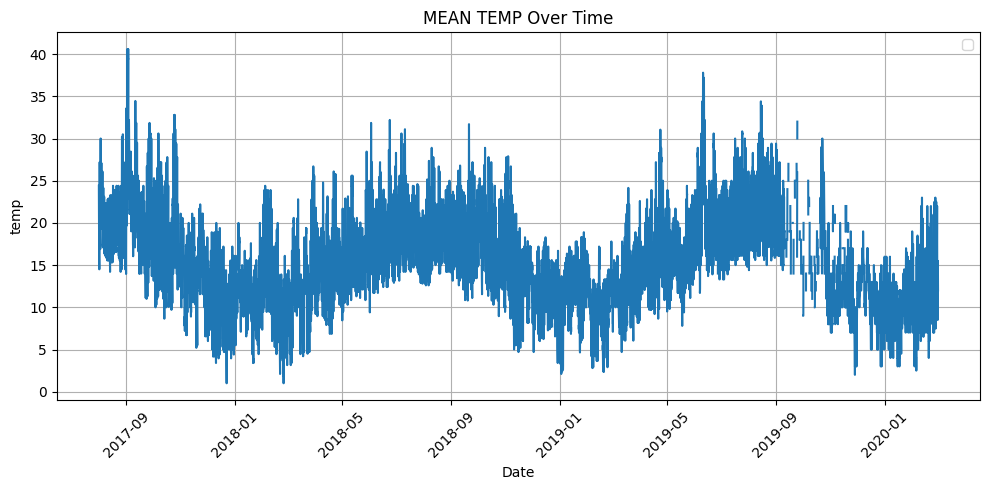

In [7]:
# Plot time series of weather event durations per hour
plot_time_series(temp_data, 'time', 'temp', agg_type='mean')

In [8]:
# Calculate ratio of hours with at least measurement for temperature to total hours in dataset
hourly_tmp_cr = ts_completeness(temp_data, 'h', 1, 'time')
print(f"Hourly temperature completeness ratio: {hourly_tmp_cr:.1%}")

Hourly temperature completeness ratio: 96.6%


In [ ]:
temp_data[temp_data['temp'].isna()]

,station,time,temp,hour,dayofyear
55,KPAO0,2018-02-11 01:00:00,<NA>,1,42
56,KPAO0,2018-02-11 02:00:00,<NA>,2,42
57,KPAO0,2018-02-15 03:00:00,<NA>,3,46
58,KPAO0,2018-02-18 17:00:00,<NA>,17,49
64,KPAO0,2018-04-04 20:00:00,<NA>,20,94
...,...,...,...,...,...
29693,KSQL0,2019-05-15 19:00:00,<NA>,19,135
29694,KSQL0,2019-05-15 20:00:00,<NA>,20,135
31088,KSQL0,2019-12-18 22:00:00,<NA>,22,352
31163,KSQL0,2019-12-23 17:00:00,<NA>,17,357


: 

In [10]:
# To impute missing values we will take the average value for temperature for each hour of the day and each day of the year across the entire temp_data df

temp_data['hour'] = temp_data['time'].dt.hour
temp_data['dayofyear'] = temp_data['time'].dt.dayofyear

avg_tmp_hour_day = (
    temp_data.groupby(['dayofyear', 'hour'])['temp']
      .mean()
      .round(2)
      .rename('clim_temp')
)

# Merge back to temp_data
temp_data_imp = temp_data.merge(avg_tmp_hour_day, on=['dayofyear', 'hour'], how='left')

# 2. Impute missing temps using climatology
temp_data_imp['temp_imputed'] = temp_data_imp['temp'].fillna(temp_data_imp['clim_temp'])

In [11]:
display(temp_data_imp[temp_data_imp['temp'].isna()])

,station,time,temp,hour,dayofyear,clim_temp,temp_imputed
55,KPAO0,2018-02-11 01:00:00,<NA>,1,42,16.75,16.75
56,KPAO0,2018-02-11 02:00:00,<NA>,2,42,14.4,14.4
57,KPAO0,2018-02-15 03:00:00,<NA>,3,46,11.08,11.08
58,KPAO0,2018-02-18 17:00:00,<NA>,17,49,10.87,10.87
64,KPAO0,2018-04-04 20:00:00,<NA>,20,94,16.82,16.82
...,...,...,...,...,...,...,...
29693,KSQL0,2019-05-15 19:00:00,<NA>,19,135,16.63,16.63
29694,KSQL0,2019-05-15 20:00:00,<NA>,20,135,18.85,18.85
31088,KSQL0,2019-12-18 22:00:00,<NA>,22,352,16.65,16.65
31163,KSQL0,2019-12-23 17:00:00,<NA>,17,357,8.9,8.9


# 99. Conclusion

Fairly sparse distribution of events with some very large outliers for duration, but usable amount of data.

Window features will be necessary to extract value from weather data.

Temperature data is very complete, imputation based on mean values is a good options.